Importation des modules

In [1]:
#pip install -r requirements.txt

Inférence

C:\Users\alexi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\alexi\AppData\Local\Temp\ipykernel_13248\2548019391.py:15: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:


Using device: cpu


100%|██████████| 45/45 [09:51<00:00, 13.14s/it]


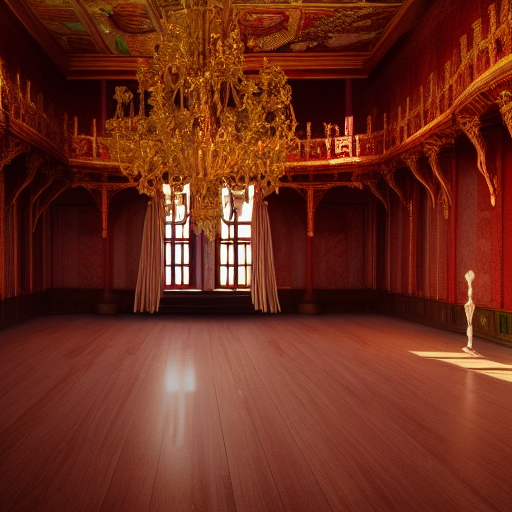

In [ ]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

prompt = "A dancing hall in a castle, highly detailed, ultra sharp, cinematic, 8k resolution, 100mm lens."
uncond_prompt = ""  #Prompt négatif
do_cfg = True
cfg_scale = 8  # entre 1 et 14, indique a quel point l'IA va faire attention au prompt

## IMAGE TO IMAGE

input_image = None
image_path = "../images/.jpg"
#Décommenter pour faire la diffusion image a image
#input_image = Image.open(image_path)

#Quantité de bruit ajouté à l'image (entre 0 et 1). Plus il y a de bruit plus l'IA pourra modifier l'image
strength = 0.9

## SAMPLER
sampler = "ddpm"
n_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=n_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Affiche l'image obtenue
Image.fromarray(output_image)